## Setup

In [1]:
!nvidia-smi

Sun Sep 26 14:06:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!pip install -q tensorflow-addons

     |████████████████████████████████| 1.1 MB 6.1 MB/s 


## Data Gathering

In [2]:
!wget -q http://data.vision.ee.ethz.ch/ihnatova/camera_scene_detection_train.zip
!unzip -qq camera_scene_detection_train.zip

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from imutils import paths
from pprint import pprint
from collections import Counter
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import tensorflow_addons as tfa

SEEDS = 42

tf.random.set_seed(SEEDS)
np.random.seed(SEEDS)

## Data Parsing

In [2]:
image_paths = list(paths.list_images("training"))
np.random.shuffle(image_paths)
image_paths[:5]

['training/29_QR_images/14.jpg',
 'training/4_Dog/219.jpg',
 'training/17_Cloudy_Sky/174.jpg',
 'training/12_Landscape/46.jpg',
 'training/22_Stage_concert/234.jpg']

## Counting number of images for each classes

In [3]:
labels = []
for image_path in image_paths:
    label = image_path.split("/")[1]
    labels.append(label)
class_count = Counter(labels) 
pprint(class_count)

Counter({'4_Dog': 502,
         '14_Architecture': 463,
         '15_Sunset_Sunrise': 420,
         '7_Food': 400,
         '5_Cat': 373,
         '6_Macro': 357,
         '9_Mountain': 352,
         '11_Snow': 344,
         '12_Landscape': 335,
         '8_Beach': 334,
         '10_Waterfall': 326,
         '2_Group_portrait': 324,
         '22_Stage_concert': 322,
         '16_Blue_Sky': 322,
         '1_Portrait': 319,
         '23_Fireworks': 317,
         '21_Night_shot': 316,
         '24_Candle_light': 313,
         '30_Computer_Screens': 308,
         '17_Cloudy_Sky': 307,
         '28_Text_Documents': 306,
         '26_Indoor': 298,
         '13_Underwater': 296,
         '19_Autumn_leaves': 295,
         '18_Greenery': 294,
         '3_Kids': 281,
         '27_Backlight': 280,
         '20_Flower': 279,
         '25_Neon_lights': 269,
         '29_QR_images': 245})


## Splitting the dataset

In [4]:
TRAIN_SPLIT = 0.9

i = int(len(image_paths) * TRAIN_SPLIT)

train_paths = image_paths[:i]
train_labels = labels[:i]
validation_paths = image_paths[i:]
validation_labels = labels[i:]

print(len(train_paths), len(validation_paths))

8907 990


## Define Hyperparameters

In [5]:
BATCH_SIZE = 128
AUTO = tf.data.AUTOTUNE
EPOCHS = 10
IMG_SIZE = 224
RESIZE_TO = 260
NUM_CLASSES = 30
TOTAL_STEPS = int((len(train_paths) / BATCH_SIZE) * EPOCHS)
WARMUP_STEPS = 10
INIT_LR = 0.03
WAMRUP_LR = 0.006

## Encoding labels

In [6]:
label_encoder = LabelEncoder()
train_labels_le = label_encoder.fit_transform(train_labels)
validation_labels_le = label_encoder.transform(validation_labels)
print(train_labels_le[:5])

[20 24  7  2 13]


## Determine the class-weights

In [7]:
trainLabels = keras.utils.to_categorical(train_labels_le)
classTotals = trainLabels.sum(axis=0)
classWeight = dict()
# loop over all classes and calculate the class weight
for i in range(0, len(classTotals)):
	classWeight[i] = classTotals.max() / classTotals[i]

## Convert the data into TensorFlow `Dataset` objects

In [8]:
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels_le))
val_ds = tf.data.Dataset.from_tensor_slices((validation_paths, validation_labels_le))

## Define the preprocessing function

In [11]:
@tf.function  
def preprocess_train(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (RESIZE_TO, RESIZE_TO))
    image = tf.image.random_crop(image, [IMG_SIZE, IMG_SIZE, 3])
    image = tf.cast(image, tf.float32) / 255.0
    return (image, label)

@tf.function
def preprocess_test(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return (image, label)

## Data Augmentation

In [12]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.02),
        tf.keras.layers.experimental.preprocessing.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)

## Create the Data Pipeline

In [13]:
pipeline_train = (
    train_ds
    .shuffle(BATCH_SIZE * 100)
    .map(preprocess_train, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

pipeline_validation = (
    val_ds
    .map(preprocess_test, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

## Visualise the training images

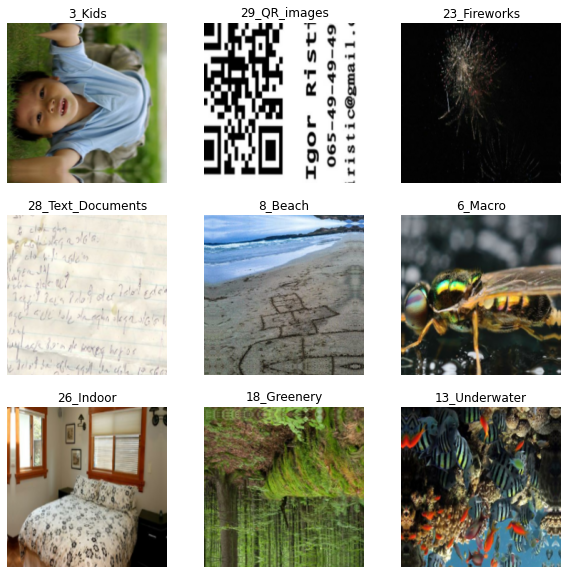

In [14]:
image_batch, label_batch = next(iter(pipeline_train))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy())
    label = label_batch[i]
    plt.title(label_encoder.inverse_transform([label.numpy()])[0])
    plt.axis("off")

## Load model into KerasLayer

In [16]:
def training_model(vit_model_url):
    model = keras.Sequential(
        [
            keras.layers.InputLayer((IMG_SIZE, IMG_SIZE, 3)),
            hub.KerasLayer(vit_model_url, trainable=True),
            keras.layers.Dense(NUM_CLASSES, activation="softmax"),
        ]
    )

    return model

In [19]:
model = training_model("https://tfhub.dev/sayakpaul/vit_s16_fe/1")

In [20]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 384)               21665664  
_________________________________________________________________
dense_3 (Dense)              (None, 30)                11550     
Total params: 21,677,214
Trainable params: 21,677,214
Non-trainable params: 0
_________________________________________________________________


## Learning Rate Scheduling

For fine-tuning

In [21]:
# Reference:
# https://www.kaggle.com/ashusma/training-rfcx-tensorflow-tpu-effnet-b2


class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super(WarmUpCosine, self).__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")
        learning_rate = (
            0.5
            * self.learning_rate_base
            * (
                1
                + tf.cos(
                    self.pi
                    * (tf.cast(step, tf.float32) - self.warmup_steps)
                    / float(self.total_steps - self.warmup_steps)
                )
            )
        )

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )

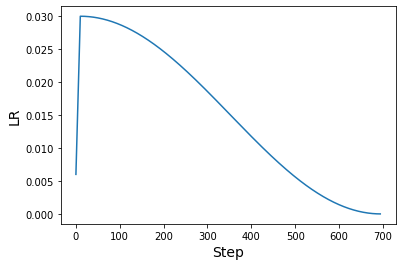

In [22]:
scheduled_lrs = WarmUpCosine(
    learning_rate_base=INIT_LR,
    total_steps=TOTAL_STEPS,
    warmup_learning_rate=WAMRUP_LR,
    warmup_steps=WARMUP_STEPS,
)

lrs = [scheduled_lrs(step) for step in range(TOTAL_STEPS)]
plt.plot(lrs)
plt.xlabel("Step", fontsize=14)
plt.ylabel("LR", fontsize=14)
plt.show()

## Define optimizer and loss

In [23]:
optimizer = keras.optimizers.SGD(scheduled_lrs, clipnorm=1.0)
loss_fn = keras.losses.SparseCategoricalCrossentropy()

## Compile the model

In [24]:
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

## Setup Callbacks

In [25]:
train_callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    keras.callbacks.CSVLogger('./train-logs.csv'),
    keras.callbacks.TensorBoard(histogram_freq=1)
]

## Train the model

In [26]:
history = model.fit(
    pipeline_train,
    batch_size=BATCH_SIZE,
    epochs= EPOCHS, 
    validation_data=pipeline_validation,
    class_weight=classWeight,
    callbacks=train_callbacks)

Epoch 1/10
70/70 [==============================] - 186s 2s/step - loss: 1.8713 - accuracy: 0.7042 - val_loss: 0.3002 - val_accuracy: 0.9121
Epoch 2/10
70/70 [==============================] - 135s 2s/step - loss: 0.3022 - accuracy: 0.9394 - val_loss: 0.1779 - val_accuracy: 0.9354
Epoch 3/10
70/70 [==============================] - 138s 2s/step - loss: 0.1715 - accuracy: 0.9645 - val_loss: 0.1476 - val_accuracy: 0.9576
Epoch 4/10
70/70 [==============================] - 138s 2s/step - loss: 0.1065 - accuracy: 0.9759 - val_loss: 0.1568 - val_accuracy: 0.9606
Epoch 5/10
70/70 [==============================] - 138s 2s/step - loss: 0.0714 - accuracy: 0.9839 - val_loss: 0.1617 - val_accuracy: 0.9606
Epoch 6/10
70/70 [==============================] - 138s 2s/step - loss: 0.0464 - accuracy: 0.9900 - val_loss: 0.1314 - val_accuracy: 0.9636
Epoch 7/10
70/70 [==============================] - 138s 2s/step - loss: 0.0312 - accuracy: 0.9925 - val_loss: 0.1258 - val_accuracy: 0.9677
Epoch 8/10
70

## Plot the Metrics

In [27]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("Training Progress")
    plt.ylabel("Accuracy/Loss")
    plt.xlabel("Epochs")
    plt.legend(["train_acc", "val_acc", "train_loss", "val_loss"], loc="upper left")
    plt.show()

## Evaluate the model

8/8 [==============================] - 4s 442ms/step - loss: 0.1339 - accuracy: 0.9687
Accuracy: 96.87%


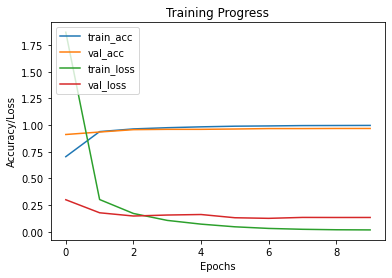

In [28]:
accuracy = model.evaluate(pipeline_validation)[1] * 100
print("Accuracy: {:.2f}%".format(accuracy))
plot_hist(history)

## Upload the TensorBoard logs

In [ ]:
!tensorboard dev upload --logdir logs --name "ViT-S16 Model" --description "ViT S16 model trained on Image-Scene-Dataset" 

**Link:** https://tensorboard.dev/experiment/m9OMnYIzTw66LWXvyXCYgg/